In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_uniform, make_joint, make_joint3

In [3]:
df = pd.read_csv(Path.cwd() / 'data' / '2239075.csv', usecols= ['DATE', 'SNOW'], parse_dates=['DATE'])
df['YEAR'] = df['DATE'].dt.year
df.head()


,DATE,SNOW,YEAR
0,1967-05-11,0.0,1967
1,1967-05-12,0.0,1967
2,1967-05-13,0.0,1967
3,1967-05-14,0.0,1967
4,1967-05-15,0.0,1967


In [4]:
snow = df.groupby('YEAR')['SNOW'].sum()
snow.head()

YEAR
1967    28.6
1968    44.7
1969    99.2
1970    66.8
1971    54.6
Name: SNOW, dtype: float64

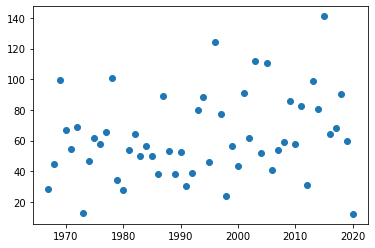

In [6]:
plt.scatter(x=snow.index, y=snow.values)

In [7]:
pmf_snowfall = Pmf.from_seq(snow)
mean, std = pmf_snowfall.mean(), pmf_snowfall.std()

In [8]:
dist = ss.norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

<AxesSubplot:>

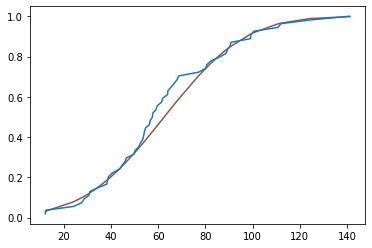

In [9]:
plt.plot(qs, ps, color='C5', label='model')
pmf_snowfall.make_cdf().plot(label='data')

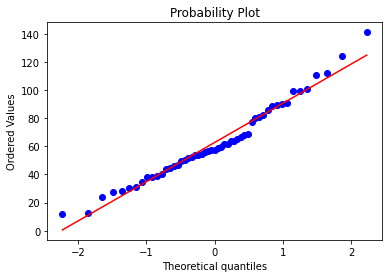

In [12]:
# qq plot을 그려서 정규성 확인
ss.probplot(pmf_snowfall.qs, dist=ss.norm, plot=plt)
plt.show()

In [13]:
data = snow.reset_index()
offset = round(data['YEAR'].mean(), 0)
data['x'] = data['YEAR'] - offset
data['y'] = data['SNOW']

In [14]:
formula = 'y ~ x'
results = smfa.ols(formula, data=data).fit()
# 잔차의 std는 sigma의 추정값
results.params, results.resid.std()

(Intercept    62.780489
 x             0.423941
 dtype: float64,
 26.56611464774299)

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.277
Date:                Sat, 16 Sep 2023   Prob (F-statistic):             0.0760
Time:                        12:11:03   Log-Likelihood:                -253.22
No. Observations:                  54   AIC:                             510.4
Df Residuals:                      52   BIC:                             514.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.7805      3.652     17.192      0.000      55.453      70.108
x              0.4239      0.234      1.810      0.076      -0.046       0.894
==============================================================================
Omnibus:                        2.563   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                1.885
Skew:                           0.449   Prob(JB):                        0.390
Kurtosis:                       3.173   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# prior의 길이를 다르게 만든 이유 → 더 중요한 파라미터(slope)에 더 자세하게
qs1 = np.linspace(-0.5, 1.4, 51)
prior_slope = make_uniform(qs1, name='Slope')
qs2 = np.linspace(53, 71, 41)
prior_inter = make_uniform(qs2, name='Intercept')
qs3 = np.linspace(20, 33, 21)
prior_sigma = make_uniform(qs3, name='Sigma')

In [19]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior

-0.5  53.0  20.00    0.000023
            20.65    0.000023
            21.30    0.000023
            21.95    0.000023
            22.60    0.000023
                       ...   
 1.4  71.0  30.40    0.000023
            31.05    0.000023
            31.70    0.000023
            32.35    0.000023
            33.00    0.000023
Name: , Length: 43911, dtype: float64

In [20]:
# 모수들을 알고 있다고 가정 → 흐름을 파악하기 위한 임시 작업
inter = 63
slope = 0.42
sigma = 27

In [21]:
xs = data['x']
ys = data['y']
expected = inter + slope*xs
resid = ys - expected
densities = ss.norm(0, sigma).pdf(resid)
likelihood = densities.prod()
likelihood

1.0298257696756573e-110

In [24]:
likelihood = prior.copy()
for slope, inter, sigma in prior.copy().index:
    expected = inter + slope*xs
    resid = ys - expected
    densities = ss.norm(0, sigma).pdf(resid)
    likelihood[slope, inter, sigma] = densities.prod()

In [25]:
posterior = prior * likelihood
posterior.normalize()

7.388832335294881e-112

In [26]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

(62.70462674233206, array([56.6, 68.3]))

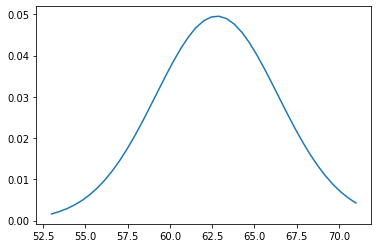

In [27]:
posterior_inter.plot()
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(0.42382562392867706, array([0.032, 0.83 ]), array(-0.082), array(0.04249183))

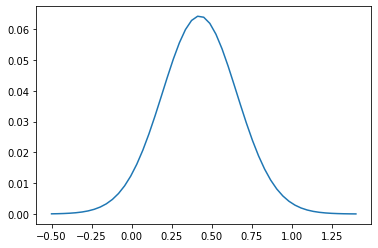

In [28]:
posterior_slope.plot()
posterior_slope.mean(), posterior_slope.credible_interval(0.9), posterior_slope.quantile(0.02), posterior_slope.make_cdf()(0)

In [29]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
table = pd.read_html(url)[0]
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['time'] = pd.to_timedelta(table['Time'])
# 42.195 / 1.61
table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh, Scotland",ARRS[9],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch, New Zealand",ARRS[9],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[9],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[9],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[9]",NaN,1981-12-06,0 days 02:08:18,12.252533


In [30]:
offset = pd.to_datetime('1995')
timedelta = data['date'] - offset
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y,x
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh, Scotland",ARRS[9],NaN,1970-07-23,0 days 02:09:28.800000,12.140871,-24.444201
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch, New Zealand",ARRS[9],NaN,1974-01-31,0 days 02:09:12,12.167183,-20.917753
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[9],NaN,1978-02-05,0 days 02:09:05.600000,12.177236,-16.903954
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[9],NaN,1980-04-26,0 days 02:09:01,12.184472,-14.683496
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[9]",NaN,1981-12-06,0 days 02:08:18,12.252533,-13.070858


In [31]:
formula = 'y ~ x'
results = smfa.ols(formula, data=data).fit()
results.params, results.resid.std()

(Intercept    12.464040
 x             0.015931
 dtype: float64,
 0.04419653543387639)

In [32]:
results.summary()

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     580.6
Date:                Sat, 16 Sep 2023   Prob (F-statistic):           1.40e-14
Time:                        12:23:55   Log-Likelihood:                 32.817
No. Observations:                  19   AIC:                            -61.63
Df Residuals:                      17   BIC:                            -59.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4640      0.011   1183.584      0.000      12.442      12.486
x              0.0159      0.001     24.095      0.000       0.015       0.017
==============================================================================
Omnibus:                        1.855   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.396   Jarque-Bera (JB):                1.347
Skew:                           0.443   Prob(JB):                        0.510
Kurtosis:                       2.043   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
qs1 = np.linspace(0.012, 0.018, 51)
prior_slope = make_uniform(qs1, name='Slope')
qs2 = np.linspace(12.0, 13.2, 41)
prior_inter = make_uniform(qs2, name='Intercept')
qs3 = np.linspace(0.01, 0.11, 11)
prior_sigma = make_uniform(qs3, name='Sigma')

In [34]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior

0.012  12.0  0.01    0.000043
             0.02    0.000043
             0.03    0.000043
             0.04    0.000043
             0.05    0.000043
                       ...   
0.018  13.2  0.07    0.000043
             0.08    0.000043
             0.09    0.000043
             0.10    0.000043
             0.11    0.000043
Name: , Length: 23001, dtype: float64

In [35]:
xs = data['x']
ys = data['y']
likelihood = prior.copy()
for slope, inter, sigma in prior.index:
    expected = inter + slope * xs
    resid = ys - expected
    densities = ss.norm(0, sigma).pdf(resid)
    likelihood[slope, inter, sigma] = densities.prod()

In [36]:
posterior = prior * likelihood
posterior.normalize()

153433648360.85608

In [37]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

(12.463249484305965, array([12.45, 12.48]))

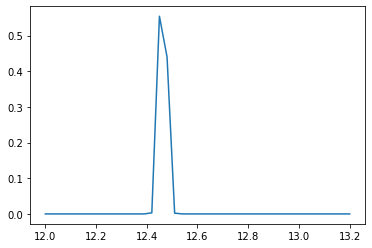

In [38]:
posterior_inter.plot()
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(0.015928336190225528, array([0.01476, 0.01716]), array(0.01596))

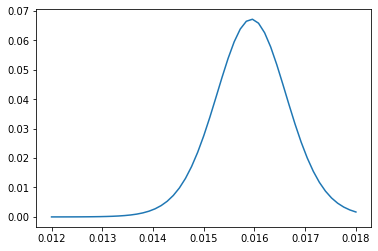

In [39]:
posterior_slope.plot()
posterior_slope.mean(), posterior_slope.credible_interval(0.9), posterior_slope.quantile(0.5)

In [42]:
# 각 세 파라미터와 관련하여 랜덤으로 추출
sample = posterior.choice(1001)
xs = np.arange(-25, 50)
pred = np.zeros((len(sample), len(xs)))
for i, (slope, inter, sigma) in enumerate(sample):
    # 확률변수에 따른 잔차 생성 → len(xs)개
    epsilon = ss.norm(0, sigma).rvs(len(xs))
    pred[i] = inter + slope * xs + epsilon

In [50]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
low, median, high

(array([11.97181401, 11.99082174, 12.00575385, 12.02652523, 12.03750253,
        12.05749668, 12.07149166, 12.08535526, 12.0964683 , 12.1213904 ,
        12.13714033, 12.15476814, 12.17145604, 12.18810952, 12.20144444,
        12.21241873, 12.22860634, 12.24289836, 12.26327049, 12.27502401,
        12.30079488, 12.30610038, 12.324376  , 12.34071221, 12.35791535,
        12.37789202, 12.3894454 , 12.408667  , 12.42747111, 12.44828477,
        12.46019971, 12.47070097, 12.48896454, 12.5043575 , 12.51856352,
        12.5343857 , 12.54651876, 12.56678447, 12.58075802, 12.59839018,
        12.60885468, 12.62881218, 12.64197381, 12.66510299, 12.67446371,
        12.69294634, 12.71060155, 12.72716533, 12.73867862, 12.75646696,
        12.76450492, 12.78756461, 12.80270016, 12.81855054, 12.83930217,
        12.84713642, 12.86877665, 12.87821853, 12.90071881, 12.90914751,
        12.92941255, 12.93615553, 12.95751676, 12.97122849, 12.98811856,
        13.00408267, 13.01291246, 13.03373259, 13.0

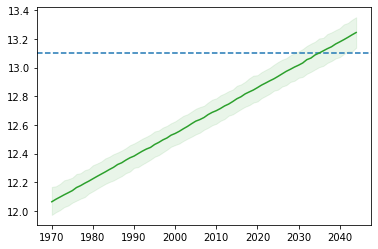

In [51]:
times = pd.to_timedelta(xs * 365.24, unit='days') + offset
plt.axhline(13.1, linestyle='--')
plt.fill_between(times, low, high, color='C2', alpha=0.1)
plt.plot(times, median, color='C2')

In [52]:
interp1d(high, xs)(13.1)

array(33.98583922)

In [53]:
future = np.array([interp1d(high, xs)(13.1), interp1d(median, xs)(13.1), interp1d(low, xs)(13.1)])
future_times = pd.to_timedelta(future * 365.24, unit='days') + offset
future_times

DatetimeIndex(['2028-12-25 23:42:36.088070400',
               '2034-10-19 12:40:31.511913600',
               '2041-07-03 20:32:48.257548800'],
              dtype='datetime64[ns]', freq=None)